In [14]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Downloading the Data from Yahoo Finance Site

df = yf.download('AAPL', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [16]:
# Previous index was Date, Resetting it to default

df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449402,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314880,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970078,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143898,132079200


## Technical Analysis

In [17]:
import ta

In [18]:
import pandas as pd

def calculate_macd(df: pd.DataFrame, close_column: str, ema_12_period: int = 12, ema_26_period: int = 26, signal_period: int = 9) -> pd.DataFrame:
    """
    Calculates the MACD indicator and returns a DataFrame with the MACD line, signal line, and histogram values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        close_column (str): The name of the column containing the closing price data.
        ema_12_period (int): The period for the 12-period EMA. Defaults to 12.
        ema_26_period (int): The period for the 26-period EMA. Defaults to 26.
        signal_period (int): The period for the signal line. Defaults to 9.

    Returns:
        pd.DataFrame: The DataFrame with the MACD values added as new columns.
    """

    # Calculate 12-period EMA
    ema_12 = df[close_column].ewm(span=ema_12_period, adjust=False).mean()

    # Calculate 26-period EMA
    ema_26 = df[close_column].ewm(span=ema_26_period, adjust=False).mean()

    # Calculate MACD line
    macd = ema_12 - ema_26

    # Calculate signal line
    signal = macd.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD histogram
    histogram = macd - signal

    # Assign MACD values to new columns in the DataFrame
    df['macd'] = macd
    df['signal'] = signal
    df['histogram'] = histogram

    return df


In [19]:
def calculate_macd_trading_signal(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the MACD trading signal and returns a DataFrame with the trading signal values.

    Args:
        df (pd.DataFrame): The DataFrame containing the MACD data.

    Returns:
        pd.DataFrame: The DataFrame with the trading signal values added as a new column.
    """

    # Initialize trading signal column
    df['trading_signal_macd'] = np.nan

    # Buy signals
    df.loc[df['macd'] > df['signal'], 'trading_signal_macd'] = 1

    # Sell signals
    df.loc[df['macd'] < df['signal'], 'trading_signal_macd'] = -1

    # Set the value of the trading signal to 1 when the MACD histogram is positive and increasing
    df.loc[(df['histogram'] > 0) & (df['histogram'] > df['histogram'].shift()), 'trading_signal_macd'] = 1

    # Set the value of the trading signal to -1 when the MACD histogram is negative and decreasing
    df.loc[(df['histogram'] < 0) & (df['histogram'] < df['histogram'].shift()), 'trading_signal_macd'] = -1

    # Fill the missing values with last valid observation
    df = df.fillna(method='ffill')

    return df

In [20]:
import pandas as pd

def calculate_macd_strategy_returns(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate daily returns
    df['returns'] = df.Close.pct_change()

    # Calculate daily strategy returns
    df['strategy_returns_macd'] = df.returns * df.trading_signal_macd.shift(1)

    # Calculate cumulative strategy returns
    cumulative_strategy_returns = (df.strategy_returns_macd + 1).cumprod()

    # Add the cumulative returns to the DataFrame
    df['cumulative_strategy_returns_macd'] = cumulative_strategy_returns

    return df


In [21]:
import pandas as pd

def calculate_cagr(cumulative_strategy_returns: pd.Series) -> float:
    # Total number of trading days
    days = len(cumulative_strategy_returns)

    # Calculate compounded annual growth rate
    annual_returns = (cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100

    return annual_returns

In [22]:
def sharpe_ratio(df, risk_free_rate):
    """
    Calculates the Sharpe ratio based on a DataFrame of daily returns and a given annual risk-free rate.

    Parameters:
    df (pandas.DataFrame): A DataFrame of daily returns.
    risk_free_rate (float): The annual risk-free rate.

    Returns:
    float: The Sharpe ratio.
    """
    daily_risk_free_return = risk_free_rate / 252
    excess_daily_returns = df - daily_risk_free_return
    return (excess_daily_returns.mean() / excess_daily_returns.std()) * np.sqrt(252)


In [23]:
tickers = ['MSFT','AAPL','AMZN','NVDA','GOOGL','GOOG','TSLA','META','AVGO','PEP','COST','CSCO','TMUS','ADBE','TXN','CMCSA','AMD','NFLX','QCOM','INTC','AMGN','HON','INTU','SBUX','GILD','AMAT','BKNG','ADI','MDLZ','ADP','ISRG','REGN','PYPL','VRTX','FISV','LRCX','ATVI','MELI','MU','MRNA','CSX','PANW','SNPS','ASML','CDNS','MNST','KLAC','CHTR','ORLY','FTNT','MAR','KDP','ABNB','KHC','NXPI','CTAS','AEP','MCHP','LULU','ADSK','PDD','DXCM','AZN','WDAY','EXC','IDXX','PAYX','BIIB','GFS','PCAR','SGEN','ROST','XEL','ODFL','ILMN','WBD','CPRT','MRVL','EA','DLTR','CTSH','FAST','WBA','BKR','CRWD','VRSK','ANSS','CSGP','ENPH','FANG','ALGN','CEG','TEAM','EBAY','DDOG','JD','ZM','ZS','SIRI','LCID','RIVN']

In [30]:
for ticker in tickers[:4]:
    temp = yf.download(ticker, start='2018-01-01')
    
    df = calculate_macd(temp,'Close')
    df = calculate_macd_trading_signal(df)
    df = calculate_macd_strategy_returns(df)
#     print(calculate_cagr(df['cumulative_strategy_returns_macd']))
    print(sharpe_ratio(df, 0.02))
    
    print(" ")
    

[*********************100%***********************]  1 of 1 completed
Open                                42.214175
High                                42.217663
Low                                 42.214601
Close                               42.212123
Adj Close                           40.872228
Volume                              37.676835
macd                                 4.518847
signal                               4.798241
histogram                            0.303225
trading_signal_macd                  1.247172
returns                              0.821260
strategy_returns_macd               -0.637239
cumulative_strategy_returns_macd    46.144551
dtype: float64
 
[*********************100%***********************]  1 of 1 completed
Open                                34.342150
High                                34.320576
Low                                 34.380899
Close                               34.346864
Adj Close                           33.630905
Volume           

In [119]:
stocks = df

In [120]:
# arithmetic mean daily return
stocks.pct_change(1).mean()

MSFT    0.001107
AAPL    0.001218
AMZN    0.000665
NVDA    0.001831
dtype: float64

In [121]:
#log daily return
log_return = np.log(stocks/stocks.shift(1))

In [122]:
print(stocks.columns)

Index(['MSFT', 'AAPL', 'AMZN', 'NVDA'], dtype='object')


In [125]:
weights = np.array(np.random.random(4))
weights = weights/np.sum(weights)

In [126]:
weights

array([0.03190219, 0.36198675, 0.12231861, 0.48379245])

In [127]:
# expected return
print('Expected Portfolio Return')
exp_ret = np.sum((log_return.mean()*weights)*252)
print(exp_ret)

Expected Portfolio Return
0.26860906976182725


In [128]:
# expected volatility
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))
print(exp_vol)

Expected Volatility
0.38360608388342154


In [129]:
# Sharpe Ratio
print('Sharpe Ratio')
SR = exp_ret/exp_vol
print(SR)

Sharpe Ratio
0.7002210888903888


In [131]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    # weights 
    weights = np.array(np.random.random(4)) 
    weights = weights/np.sum(weights)  
	
    # save the weights
    all_weights[ind,:] = weights
	
    # expected return 
    ret_arr[ind] = np.sum((log_return.mean()*weights)*252)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [132]:
sharpe_arr.max()

0.8022915962776735

Text(0, 0.5, 'Return')

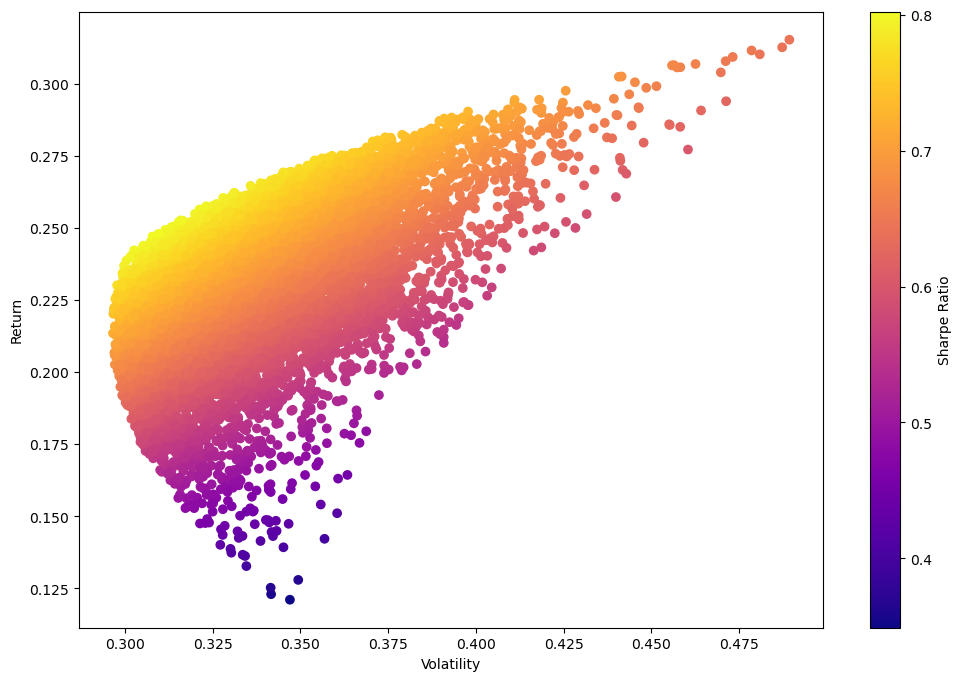

In [133]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [14]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,rsi,macd,signal,histogram,trading_signal_macd,returns,strategy_returns_macd
813,2023-03-27,159.940002,160.770004,157.869995,158.279999,158.279999,52390300,60.729218,2.923728,2.437177,0.486551,1.0,-0.012293,-0.012293
814,2023-03-28,157.970001,158.490005,155.979996,157.649994,157.649994,45992200,59.143053,2.811817,2.512105,0.299711,1.0,-0.003980,-0.003980
815,2023-03-29,159.369995,161.050003,159.350006,160.770004,160.770004,51305700,64.138514,2.940983,1.000000,0.343102,1.0,0.019791,0.019791
816,2023-03-30,161.529999,162.470001,161.270004,162.360001,162.360001,49501700,66.393567,3.135504,1.000000,0.430098,1.0,0.009890,0.009890
817,2023-03-31,162.440002,165.000000,161.910004,164.899994,164.899994,68694700,69.674229,3.454794,1.000000,0.599511,1.0,0.015644,0.015644
818,2023-04-03,164.270004,166.289993,164.220001,166.169998,166.169998,56976200,71.188695,3.766891,1.000000,0.729286,1.0,0.007702,0.007702
819,2023-04-04,166.600006,166.839996,165.110001,165.630005,165.630005,46278300,69.597193,3.925407,3.215165,0.710242,1.0,-0.003250,-0.003250
820,2023-04-05,164.740005,165.050003,161.800003,163.759995,163.759995,51511700,64.241086,3.855692,3.343270,0.512421,1.0,-0.011290,-0.011290
821,2023-04-06,162.429993,164.960007,162.000000,164.660004,164.660004,45390100,65.612734,3.828928,3.440402,0.388526,1.0,0.005496,0.005496
822,2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47672100,58.545547,3.554523,3.463226,0.091297,1.0,-0.015972,-0.015972


#### Stochastic Oscillator

In [15]:
# Applying Stochastic Oscillator

# Calculate highest high and lowest low over 14 periods
high_14 = df['High'].rolling(14).max()
low_14 = df['Low'].rolling(14).min()

# Calculate Stochastic
stochastic = 100 * (df['Close'] - low_14) / (high_14 - low_14)

# Assign Stochastic value to new column in the DataFrame
df['Stochastic'] = stochastic

# Calculate the trading signal based on the Stochastic Oscillator
stochastic_signal = np.where(stochastic > 80, -1, np.where(stochastic < 20, 1, 0))
df['stochastic_osc_signal'] = stochastic_signal

In [16]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,rsi,macd,signal,histogram,trading_signal_macd,returns,strategy_returns_macd,Stochastic,stochastic_osc_signal
813,2023-03-27,159.940002,160.770004,157.869995,158.279999,158.279999,52390300,60.729218,2.923728,2.437177,0.486551,1.0,-0.012293,-0.012293,73.434267,0
814,2023-03-28,157.970001,158.490005,155.979996,157.649994,157.649994,45992200,59.143053,2.811817,2.512105,0.299711,1.0,-0.003980,-0.003980,69.098377,0
815,2023-03-29,159.369995,161.050003,159.350006,160.770004,160.770004,51305700,64.138514,2.940983,1.000000,0.343102,1.0,0.019791,0.019791,90.571265,-1
816,2023-03-30,161.529999,162.470001,161.270004,162.360001,162.360001,49501700,66.393567,3.135504,1.000000,0.430098,1.0,0.009890,0.009890,99.255243,-1
817,2023-03-31,162.440002,165.000000,161.910004,164.899994,164.899994,68694700,69.674229,3.454794,1.000000,0.599511,1.0,0.015644,0.015644,99.336830,-1
818,2023-04-03,164.270004,166.289993,164.220001,166.169998,166.169998,56976200,71.188695,3.766891,1.000000,0.729286,1.0,0.007702,0.007702,99.266981,-1
819,2023-04-04,166.600006,166.839996,165.110001,165.630005,165.630005,46278300,69.597193,3.925407,3.215165,0.710242,1.0,-0.003250,-0.003250,92.039528,-1
820,2023-04-05,164.740005,165.050003,161.800003,163.759995,163.759995,51511700,64.241086,3.855692,3.343270,0.512421,1.0,-0.011290,-0.011290,75.728911,0
821,2023-04-06,162.429993,164.960007,162.000000,164.660004,164.660004,45390100,65.612734,3.828928,3.440402,0.388526,1.0,0.005496,0.005496,82.821180,-1
822,2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47672100,58.545547,3.554523,3.463226,0.091297,1.0,-0.015972,-0.015972,55.709049,0


In [23]:
df['stochastic_returns'] = df.Close.pct_change()

# Calculate daily strategy returns
df['stochastic_strategy_returns'] = df.stochastic_returns * df.stochastic_osc_signal.shift(1)

# Calculate cumulative strategy returns
stochastic_cumulative_strategy_returns = (df.stochastic_strategy_returns + 1).cumprod()

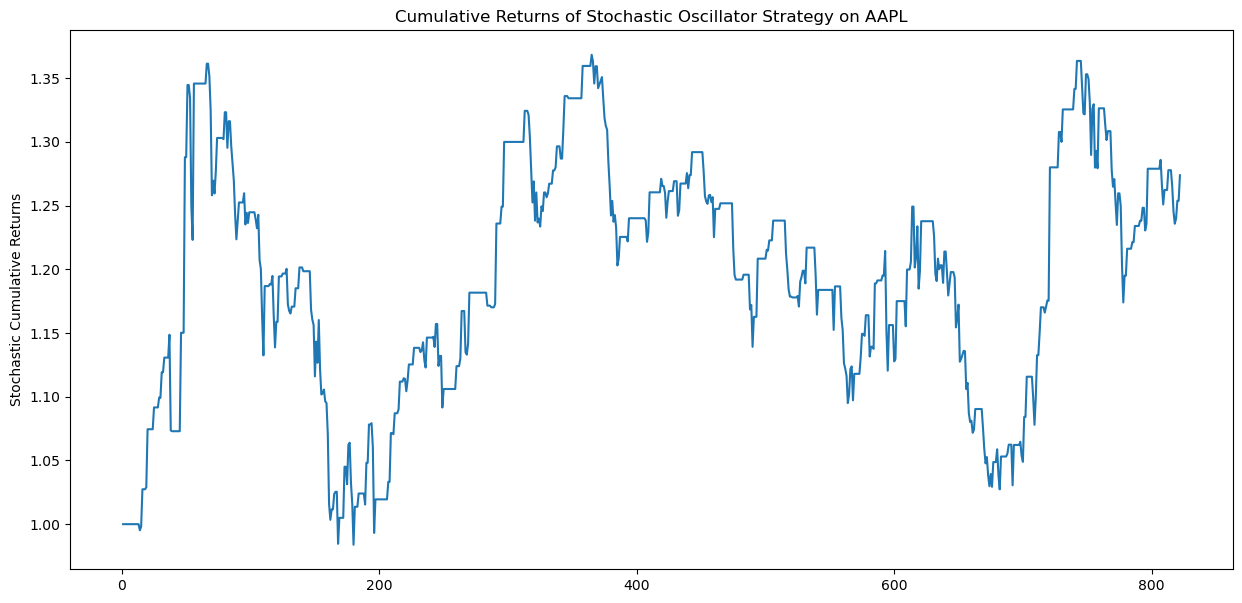

In [24]:
# Plot cumulative strategy returns
stochastic_cumulative_strategy_returns.plot(figsize=(15,7))
plt.ylabel('Stochastic Cumulative Returns')
plt.title('Cumulative Returns of Stochastic Oscillator Strategy on AAPL')
plt.show()

In [32]:
# Total number of trading days
days = len(stochastic_cumulative_strategy_returns)

# Calculate compounded annual growth rate
stochastic_annual_returns = (stochastic_cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100

print('The CAGR based on Stochastic Oscillator is %.2f%%' % stochastic_annual_returns)

The CAGR based on Stochastic Oscillator is 7.69%


In [33]:
df['trading_signal_macd'].corr(df['stochastic_osc_signal'])

-0.6181802060711539

#### On Balance Volume

In [31]:
# Applying On Balance Volume Indicator

df['OBV'] = df['Volume'].cumsum()
df['OBV_signal'] = df['OBV'].diff().apply(lambda x: 1 if x > 0 else -1)

# Calculate returns for each trade
df['Returns'] = df['Close'].pct_change() * df['OBV_signal'].shift(1)

# Calculate CAGR
start_value = df.iloc[0]['Close']
end_value = df.iloc[-1]['Close']
n_years = len(df) / 252
cagr = (end_value / start_value) ** (1 / n_years) - 1

print(f"The CAGR based on the OBV trading signal is: {cagr:.2%}")

The CAGR based on the OBV trading signal is: 26.55%


In [40]:
# Applying Technical Indicators

df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

# Moving Averages
df['7_DAYS_MA'] = df['Close'].rolling(window=7).mean()
df['14_DAYS_MA'] = df['Close'].rolling(window=14).mean()
df['21_DAYS_MA'] = df['Close'].rolling(window=21).mean()

# Standard Deviation
df['7_DAYS_STD_DEV'] = df['Close'].rolling(window=7).std()

# 7-period Exponential Moving Average
ema_period = 7
df['ema'] = df['Close'].ewm(span=ema_period, adjust=False).mean()

# 7-Period Double Exponential Moving Average
df['dema'] = 2*df['ema'] - df['Close'].ewm(span=ema_period, adjust=False).mean()

df = df[21:]

## Fundamental Analysis

In [46]:
import yahoo_fin as yfin
from yahoo_fin.stock_info import get_analysts_info

## Principal Component Analysis

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [ ]:
df = scaler.transform(df)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=4)

In [ ]:
pca.fit(df)

In [ ]:
pca_transformed = pca.transform(df)

In [ ]:
pca_transformed.shape

In [ ]:
df.shape